In [2]:
import numpy as np
from sklearn.preprocessing import normalize as sklearn_normalize

import matplotlib.pyplot as plt
import logging
import time

In [3]:

def edge_list_to_adjacency_matrix(file_path):
    """
    Convert an edge list from a text file to an adjacency matrix.
    
    Args:
        file_path (str): Path to the file containing the edge list. 
                         Each line should have 'source target weight'.
    
    Returns:
        tuple: (adj_matrix, node_list)
               adj_matrix: numpy array representing the adjacency matrix.
               node_list: list of node IDs corresponding to the rows/columns of the matrix.
    """
    # Parse the edge list file to find all unique nodes
    nodes = set()
    edges = []
    print(file_path)
    
    with open(file_path, 'r') as f:
        for line in f:
            src, tgt, weight = map(float, line.split())
            nodes.add(int(src))
            nodes.add(int(tgt))
            edges.append((int(src), int(tgt), weight))
    
    # Create a mapping of node IDs to indices
    node_list = sorted(nodes)  # Ensure consistent ordering
    node_to_index = {node: idx for idx, node in enumerate(node_list)}
    
    # Initialize an adjacency matrix
    n = len(node_list)
    adj_matrix = np.zeros((n, n))
    
    # Fill the adjacency matrix
    for src, tgt, weight in edges:
        i, j = node_to_index[src], node_to_index[tgt]
        adj_matrix[i, j] = weight
        adj_matrix[j, i] = weight  # Uncomment if the graph is undirected
    
    return adj_matrix, node_list


In [4]:

def normalize(M):
    return sklearn_normalize(M, norm="l1", axis=0)


In [8]:
def extract_clusters(M, output_file="clusters.txt", plot_heatmap=True):
    """
    Extract clusters from the final MCL matrix by identifying attractors (diagonal non-zero entries),
    plot a heatmap, and write clusters to a text file.

    Args:
        M (numpy.ndarray): Final MCL matrix.
        output_file (str): Path to the output file where clusters will be written.
        plot_heatmap (bool): Whether to plot a heatmap of the matrix.

    Returns:
        None
    """
    diagonal = np.diag(M)
    print("Diagonal values of the matrix:", diagonal)

    # Plot the matrix as a heatmap if requested
    if plot_heatmap:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 8))
        plt.title("Heatmap of Final MCL Matrix")
        plt.imshow(M, cmap="hot", interpolation="nearest")
        plt.colorbar(label="Matrix Values")
        plt.xlabel("Nodes")
        plt.ylabel("Nodes")
        plt.savefig("mcl_matrix_heatmap.png")
        plt.show()

    # Step 1: Identify attractors (non-zero diagonal entries)
    attractors = np.where(np.diag(M) > 1e-5)[0]  # Indices of attractors
    clusters = {attractor: [] for attractor in attractors}

    # Step 2: Assign nodes to attractors
    for i in range(M.shape[0]):
        # Find the attractor to which this node is most strongly connected
        strongest_attractor = np.argmax(M[i, attractors])
        if M[i, attractors[strongest_attractor]] > 1e-5:  # Only assign if significant flow
            clusters[attractors[strongest_attractor]].append(i)

    # Step 3: Write clusters to the file
    with open(output_file, "w") as f:
        for cluster_nodes in clusters.values():
            cluster_str = " ".join(map(str, sorted(cluster_nodes)))
            f.write(f"{cluster_str}\n")

    print(f"Clusters written to {output_file}")
    print("Heatmap saved as 'mcl_matrix_heatmap.png'")


In [6]:


# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def mcl(file_path, inflation, max_iter=10, epsilon=1e-2):
    """
    Perform Markov Clustering (MCL) on a graph represented by an edge list file.

    Args:
        file_path (str): Path to the file containing the edge list.
        inflation (float): Inflation parameter for the MCL algorithm.
        max_iter (int): Maximum number of iterations to perform.
        epsilon (float): Convergence threshold for the Frobenius norm.

    Returns:
        numpy.ndarray: The final matrix after MCL processing.
    """
    logging.info("Starting MCL algorithm")
    # Convert to adjacency matrix
    M, _ = edge_list_to_adjacency_matrix(file_path)

    # Into numpy
    M = np.array(M, dtype=float)
    # Initialization
    M = normalize(M)
    logging.info("Normalized initial matrix:\n%s", M)

    convergence = False
    previous_M = M
    i = 0

    while i < max_iter and not convergence:
        logging.info("Iteration %d started", i + 1)
        start_time = time.time()

        # Expansion
        M = np.matmul(M, M)
        logging.debug("After expansion:\n%s", M)

        # Inflation
        M = np.power(M, inflation)
        M = normalize(M)
        logging.debug("After inflation:\n%s", M)

        # Check convergence using Frobenius norm
        diff_norm = np.linalg.norm(previous_M - M)
        logging.info("Iteration %d: Frobenius norm difference = %.6f", i + 1, diff_norm)

        convergence = diff_norm < epsilon
        if convergence:
            logging.info("Convergence achieved at iteration %d", i + 1)

        previous_M = M
        end_time = time.time()
        iteration_time = end_time - start_time
        logging.info("Iteration %d completed in %.6f seconds", i + 1, iteration_time)

        i += 1

    # Log final matrix
    logging.info("Final matrix:\n%s", M)

    return M


2024-12-14 16:16:23,618 - INFO - Starting MCL algorithm


/Users/Andrej/Documents/MVA/PGM/Wikipedia-Clustering/crocodile_graph.txt


2024-12-14 16:16:25,516 - INFO - Normalized initial matrix:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.02173913 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
2024-12-14 16:16:25,521 - INFO - Iteration 1 started
2024-12-14 16:16:45,604 - INFO - Iteration 1: Frobenius norm difference = 45.865345
2024-12-14 16:16:45,610 - INFO - Iteration 1 completed in 20.089597 seconds
2024-12-14 16:16:45,611 - INFO - Iteration 2 started
2024-12-14 16:17:10,933 - INFO - Iteration 2: Frobenius norm difference = 10.791029
2024-12-14 16:17:10,953 - INFO - Iteration 2 completed in 25.341144 seconds
2024-12-14 16:17:10,953 - INFO - Iteration 3 started
2024-12-14 16:17:

Clusters:


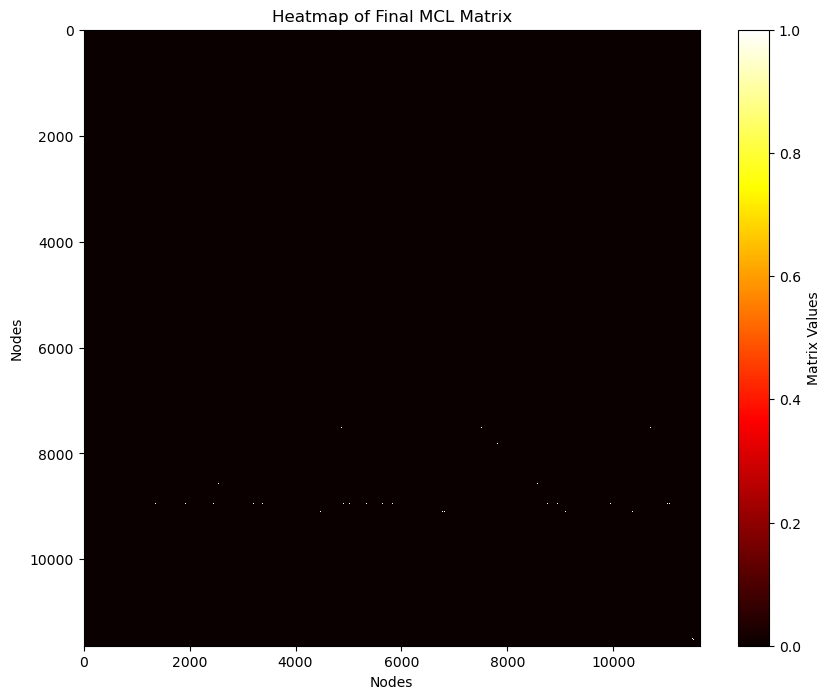

Clusters written to clusters.txt
Heatmap saved as 'mcl_matrix_heatmap.png'
None


In [7]:

# adjacency = [
#     [1, 1, 0, 0],
#     [1, 1, 1, 0],
#     [0, 1, 1, 1],
#     [0, 0, 1, 1],
# ]

# result = mcl(adjacency, inflation=2.0)
result = mcl(file_path="/Users/Andrej/Documents/MVA/PGM/Wikipedia-Clustering/crocodile_graph.txt", inflation=1.5, max_iter=100)
print("Clusters:")
print(extract_clusters(result))